In [2]:
import torch
import numpy as np
import cv2
from tifffile import imread
from scipy.ndimage import zoom
from skimage.segmentation import watershed
from scipy.ndimage import label as ndi_label
from skimage.feature import peak_local_max
from skimage.morphology import h_maxima
import sys

sys.path.insert(0, "../utils")

from utils.predict_by_parts import predict_by_parts
from norm_percentile_nocrop import norm_percentile_nocrop
from utils.get_overlaped_points import get_overlaped_points
from utils.mat2gray import mat2gray
from evaluate_detections import detect

# Load the timage and model

In [3]:
device = torch.device("cpu")
model = torch.load("detection_model.pt", map_location=torch.device("cpu"))
folder_name_to_evaluate = "../../data_zenodo/NHDF/NHDF_8h PI/IR 0,5Gy_8h PI/0001"

detection_channel = 2  # red 0, green 1, red and green 2
resized_img_size = [505, 681, 48]  # image is resized to this size
normalization_percentile = 0.0001  # image is normalized into this percentile range
crop_size = [96, 96]

In [4]:
img_filename = folder_name_to_evaluate + "/data_53BP1.tif"
img = []
img.append(imread(img_filename))  # red
img.append(imread(img_filename.replace("53BP1", "gH2AX")))  # green
img.append(imread(img_filename.replace("53BP1", "DAPI")))  # DAPI

img = np.stack(img, axis=3)

print(img.shape)

img_orig_size = img.shape[:3]
factor = np.array(resized_img_size) / np.array(img_orig_size)

tmp_size = resized_img_size.copy()
tmp_size.append(img.shape[3])
img_resized = np.zeros(tmp_size, dtype=np.float32)

for channel in range(img.shape[3]):
    data_one_channel = img[..., channel]
    data_one_channel = zoom(data_one_channel, factor, order=1)
    data_one_channel = norm_percentile_nocrop(
        data_one_channel, normalization_percentile
    )
    img_resized[..., channel] = data_one_channel

img = img_resized
img = img.astype(np.float32)
img = np.transpose(img, (3, 0, 1, 2)).copy()
img = torch.from_numpy(img)

print(img.shape)


(1010, 1362, 50, 3)
torch.Size([3, 505, 681, 48])


### Predict

In [5]:
img = img.to(device)

res = predict_by_parts(model, img, crop_size=crop_size)

img = img.detach().cpu().numpy()
res = res.detach().cpu().numpy()

100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


### Post Prediction Analysis

In [6]:
def segment_from_peaks(img, T, h, d, watershed_line=True, return_binary=False):
    # 1) peak markers (enforces min_distance = d)
    peak_idx = peak_local_max(
        img,
        min_distance=int(np.round(d)),
        threshold_abs=T
    )
    maxima1 = np.zeros_like(img, dtype=bool)
    if peak_idx.size:
        maxima1[tuple(peak_idx.T)] = True

    # 2) optional h-maxima filtering (like your current intersection)
    maxima2 = h_maxima(img, h) if h is not None else np.ones_like(img, dtype=bool)

    markers, _ = ndi_label(maxima1 & maxima2)  # labeled seeds: 1..N

    # 3) foreground definition
    mask = img >= T

    # 4) 3D watershed segmentation
    labels = watershed(-img, markers, mask=mask, watershed_line=watershed_line)

    return (labels > 0) if return_binary else labels

def detect(img, T, h, d):
    print(img.shape)
    p1 = peak_local_max(img, min_distance=int(np.round(d)), threshold_abs=T)
    p2 = np.stack(np.nonzero(h_maxima(img, h)), axis=1)

    p1 = set([tuple(x) for x in p1.tolist()])
    p2 = set([tuple(x) for x in p2.tolist()])

    detections = list(p1.intersection(p2))

    return detections

In [7]:
postprocessing_params = model.postprocessing_params[detection_channel]

detected_points = detect(res[detection_channel,:,:],postprocessing_params['T'],postprocessing_params['h'],postprocessing_params['d'])
detected_points = np.array(detected_points)

(505, 681, 48)


### Slice GIFs

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

points_channels = {}
for channel in [0, 1]:
    postprocessing_params = model.postprocessing_params[channel]
    points = detect(
        res[channel, :, :],
        postprocessing_params["T"],
        postprocessing_params["h"],
        postprocessing_params["d"],
    )
    points_channels[channel] = points

(505, 681, 48)
(505, 681, 48)


In [9]:
for channel in [0, 1]:
    for slice_idx in (15, 20, 25):
        img_select = img[channel, :, :, slice_idx]

        # Normalize to [0, 1] for display
        img_norm = (img_select - img_select.min()) / (img_select.ptp() + 1e-8)

        base_img = np.zeros((*img_select.shape, 3), dtype=np.float32)
        base_img[..., channel] = img_norm

        points = points_channels[channel]

        # Overlay points in blue
        rgb_overlay = base_img.copy()
        for point in points:
            if point[2] == slice_idx:  # Only mark points on this slice
                y, x, z = point
                if 0 <= y < rgb_overlay.shape[0] and 0 <= x < rgb_overlay.shape[1]:
                    # Mark a small region around the point
                    for dy in range(-2, 3):
                        for dx in range(-2, 3):
                            if 0 <= y+dy < rgb_overlay.shape[0] and 0 <= x+dx < rgb_overlay.shape[1]:
                                rgb_overlay[y+dy, x+dx, 2] = 1  # Blue channel

        # Convert to uint8 for GIF
        base_img_uint8 = (base_img * 255).astype(np.uint8)
        rgb_overlay_uint8 = (rgb_overlay * 255).astype(np.uint8)

        # Save as GIF, 1 second per frame, loop forever
        frames = [base_img_uint8, rgb_overlay_uint8]
        imageio.mimsave(f'model_predictions_{"red" if channel == 0 else "green"}_{slice_idx}.gif', frames, duration=1000, loop=0)

### MSER-based colocalization segmentation (53BP1 + gH2AX)

In [10]:
# MSER mask + seeded watershed on 53BP1*gH2AX colocalization
def _normalize_uint8(volume):
    vol = volume - volume.min()
    denom = volume.ptp() + 1e-8
    return (vol / denom * 255).astype(np.uint8)

def mser_mask_volume(coloc_volume, delta=2, min_area=10, max_area=500, max_variation=0.25):
    coloc_uint8 = _normalize_uint8(coloc_volume)
    mser = cv2.MSER_create(
        delta=delta,
        min_area=min_area,
        max_area=max_area,
        max_variation=max_variation
    )
    mask = np.zeros_like(coloc_uint8, dtype=np.uint8)
    for z in range(coloc_uint8.shape[2]):
        slice_img = np.ascontiguousarray(coloc_uint8[:, :, z])
        regions, _ = mser.detectRegions(slice_img)
        if not regions:
            continue
        polys = [np.asarray(r, dtype=np.int32) for r in regions if len(r) >= 3]
        if not polys:
            continue
        mask_slice = np.ascontiguousarray(mask[:, :, z])
        cv2.fillPoly(mask_slice, polys, 255)
        mask[:, :, z] = mask_slice
    return mask.astype(bool)

def seeds_from_points(points_dict, shape):
    seeds = np.zeros(shape, dtype=np.int32)
    seed_id = 1
    for pts in points_dict.values():
        for (y, x, z) in pts:
            if 0 <= y < shape[0] and 0 <= x < shape[1] and 0 <= z < shape[2]:
                if seeds[y, x, z] == 0:
                    seeds[y, x, z] = seed_id
                    seed_id += 1
    return seeds

coloc_img = img[0] * img[1]
mser_mask = mser_mask_volume(
    coloc_img,
    delta=2,
    min_area=10,
    max_area=500,
    max_variation=0.25
)
seed_labels = seeds_from_points(points_channels, coloc_img.shape)
mser_watershed_labels = watershed(-coloc_img, markers=seed_labels, mask=mser_mask)

print(f"MSER mask voxels: {mser_mask.sum()} | Watershed instances: {mser_watershed_labels.max()}")

MSER mask voxels: 1335 | Watershed instances: 302


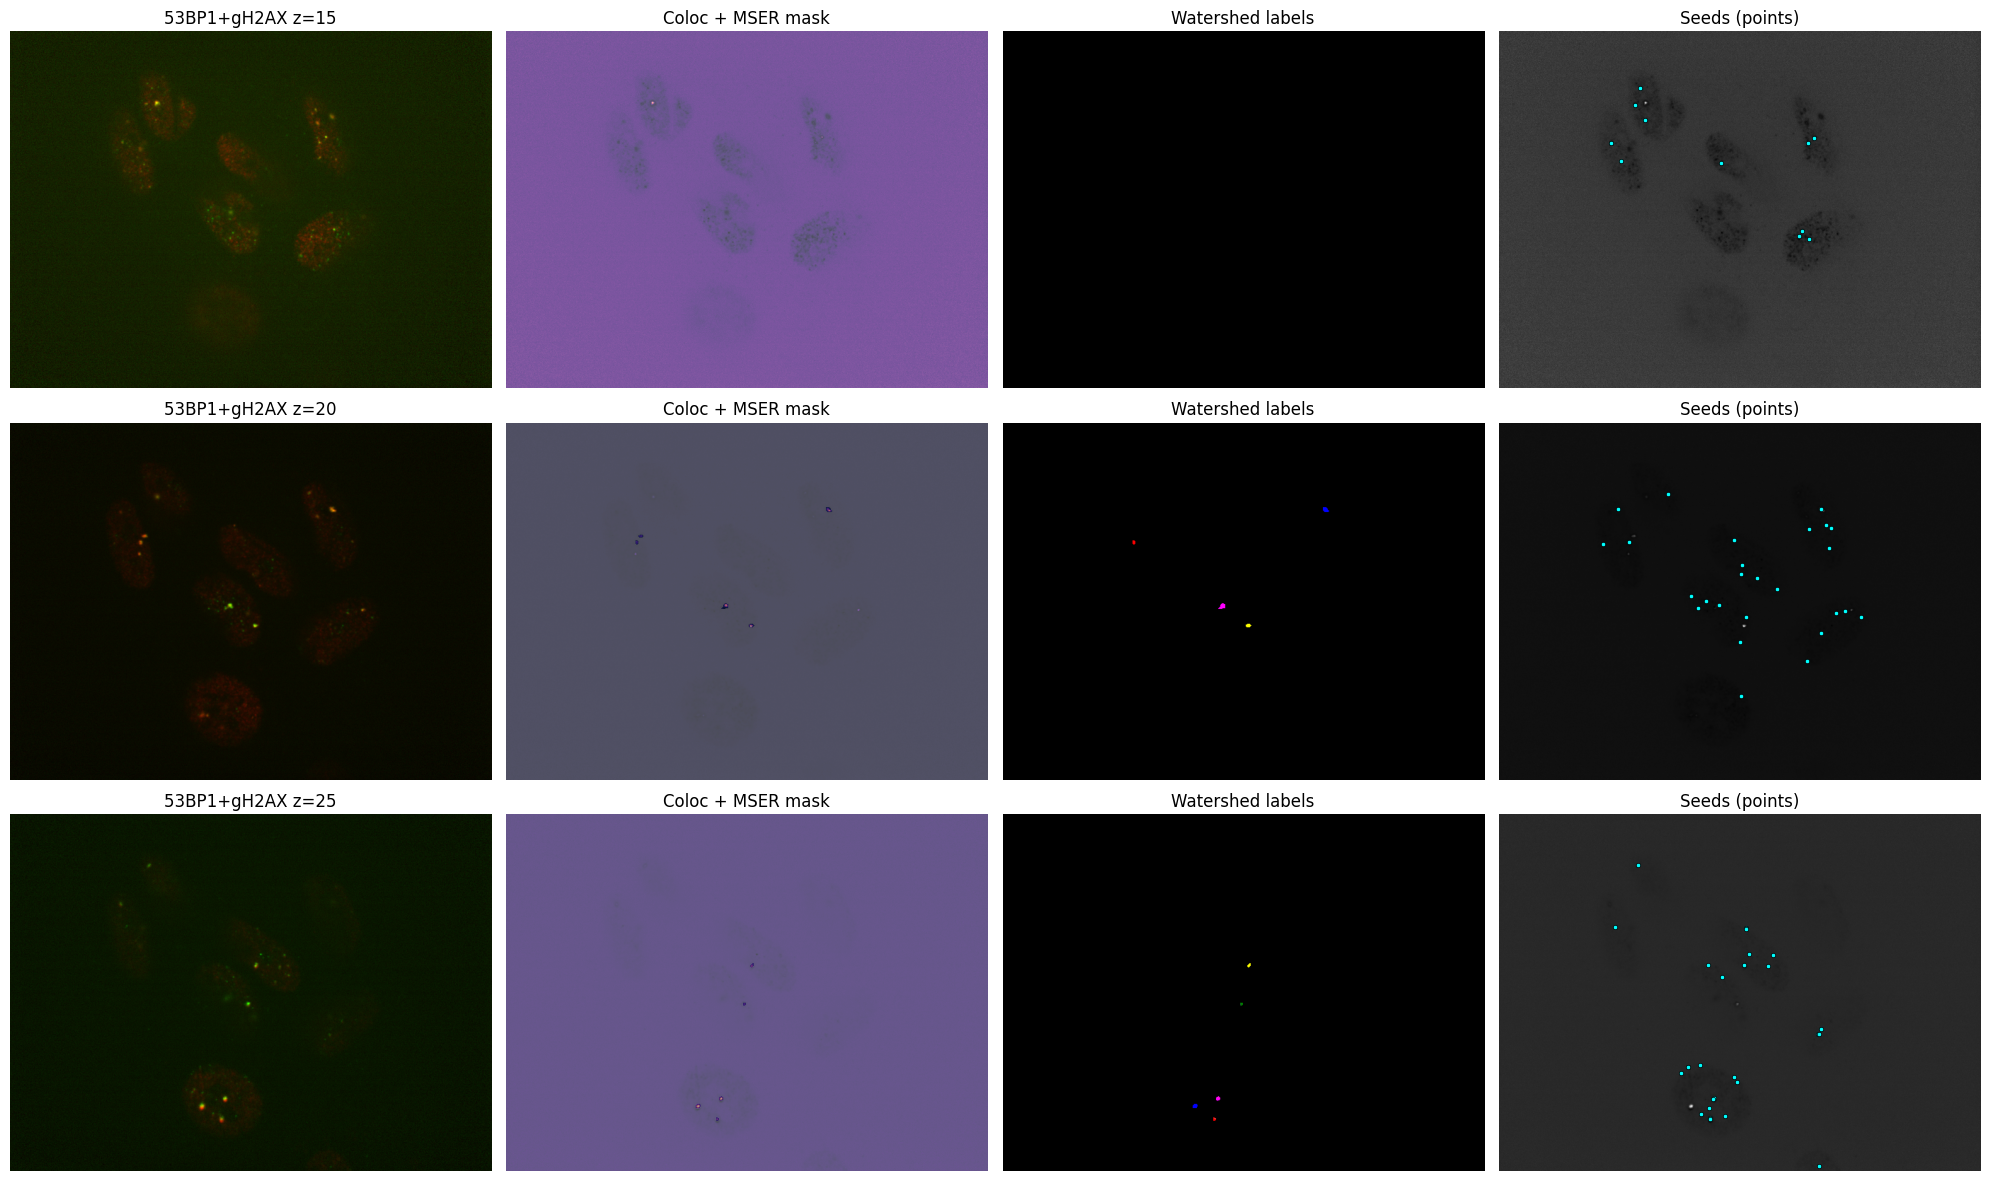

In [11]:
# Quick visual check: raw channels, MSER mask, watershed labels, seeds
import matplotlib.pyplot as plt
from skimage.color import label2rgb

slices_to_show = [15, 20, 25]  # adjust as needed

def _norm01(a):
    a = a.astype(np.float32)
    return (a - a.min()) / (a.ptp() + 1e-8)

fig, axes = plt.subplots(len(slices_to_show), 4, figsize=(20, 4 * len(slices_to_show)))
for row, z in enumerate(slices_to_show):
    red = _norm01(img[0, :, :, z])
    green = _norm01(img[1, :, :, z])
    coloc = _norm01(coloc_img[:, :, z])
    mask = mser_mask[:, :, z]
    labels = mser_watershed_labels[:, :, z]
    seeds = seed_labels[:, :, z]

    # Base channels
    axes[row, 0].imshow(np.stack([red, green, np.zeros_like(red)], axis=-1))
    axes[row, 0].set_title(f"53BP1+gH2AX z={z}")

    # Colocalization + MSER mask
    axes[row, 1].imshow(coloc, cmap="magma")
    axes[row, 1].imshow(mask, cmap="Blues", alpha=0.3)
    axes[row, 1].set_title("Coloc + MSER mask")

    # Watershed labels overlay
    axes[row, 2].imshow(coloc, cmap="gray")
    axes[row, 2].imshow(label2rgb(labels, bg_label=0, alpha=0.3))
    axes[row, 2].set_title("Watershed labels")

    # Seeds
    axes[row, 3].imshow(coloc, cmap="gray")
    ys, xs = np.nonzero(seeds)
    axes[row, 3].scatter(xs, ys, s=10, c="cyan", marker="o", edgecolor="k", linewidth=0.5)
    axes[row, 3].set_title("Seeds (points)")

for ax_row in axes:
    for ax in ax_row:
        ax.axis("off")

plt.tight_layout()
plt.show()